In [82]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math

In [83]:
# Load the dataset
file_path = 'combined_df.csv'
data = pd.read_csv(file_path)

data = data[
    (data['Year'] >= 2020) &
    (data['Headliner'].str.contains('"', na=False)) &
    (~data['Support'].isna())
  ]


/tmp/ipykernel_335209/454227074.py:3: DtypeWarning: Columns (2,3,6,7,8,9,10,28) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [84]:

# extract date features
def extract_date_features(df):
    df['Event Date'] = pd.to_datetime(df['Event Date'])
    df['Year'] = df['Event Date'].dt.year
    df['Month'] = df['Event Date'].dt.month
    df['Day of Week'] = df['Event Date'].dt.dayofweek
    return df


In [91]:

data = extract_date_features(data)

# target var and features
target = 'Avg. Gross USD'
features = ['Number of Shows', 'Avg. Event Capacity', 'Ticket Price Min USD', 'Ticket Price Max USD', 
            'City', 'Month', 'Day of Week']


In [92]:

# cols_to_convert = [
#     'Avg. Gross USD', 'Avg. Tickets Sold', 'Avg. Event Capacity', 
#     'Ticket Price Min USD', 'Ticket Price Max USD', 'Ticket Price Avg. USD'
# ]
# for col in cols_to_convert:
#     data[col] = pd.to_numeric(data[col].str.replace('[^0-9.]', '', regex=True), errors='coerce')



Text(0, 0.5, 'Frequency')

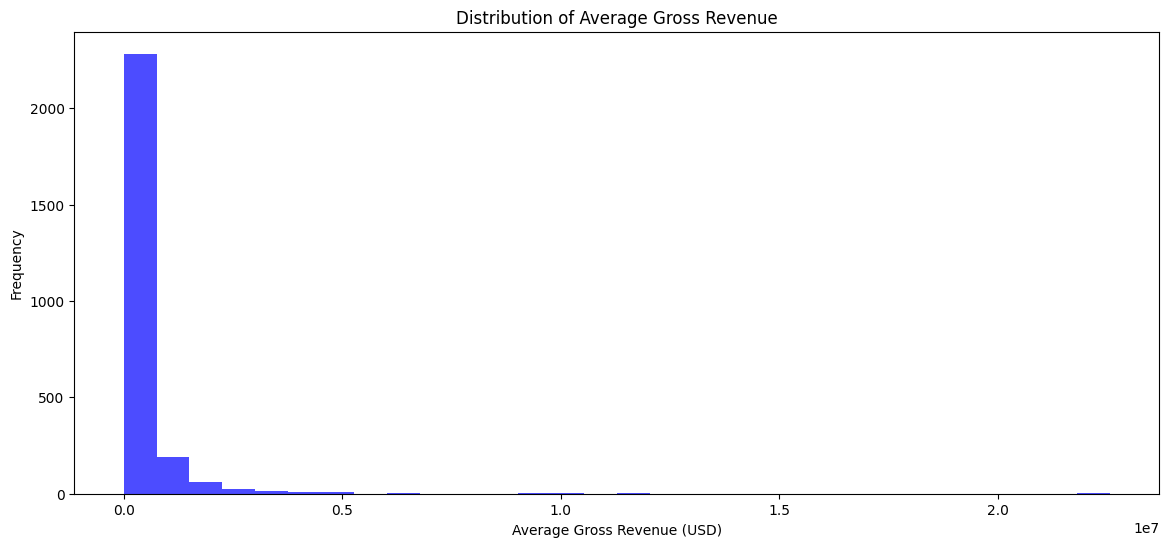

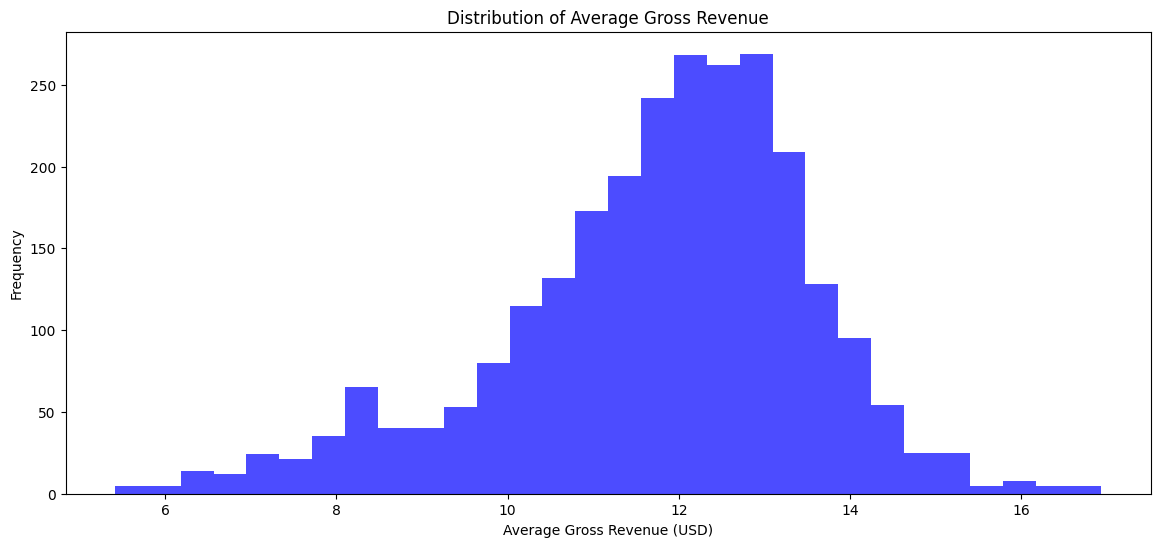

In [93]:
# Histograms for average gross revenue and log
plt.figure(figsize=(14, 6))

plt.hist(data['Avg. Gross USD'].dropna(), bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Average Gross Revenue')
plt.xlabel('Average Gross Revenue (USD)')
plt.ylabel('Frequency')

plt.figure(figsize=(14, 6))

plt.hist(np.log(data['Avg. Gross USD'].dropna()), bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Average Gross Revenue')
plt.xlabel('Average Gross Revenue (USD)')
plt.ylabel('Frequency')


In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2608 entries, 100 to 109682
Data columns (total 54 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Event Date                       2608 non-null   datetime64[ns]
 1   Headliner                        2608 non-null   object        
 2   sp artist_name                   92 non-null     object        
 3   sp artist_genre                  92 non-null     object        
 4   sp followers                     92 non-null     float64       
 5   sp popularity                    92 non-null     float64       
 6   yt name                          85 non-null     object        
 7   yt Channel ID                    85 non-null     object        
 8   yt Title                         85 non-null     object        
 9   yt Description                   47 non-null     object        
 10  yt Published At                  85 non-null     object      

In [95]:
# preprocessors
numerical_features = ['Number of Shows', 'Avg. Event Capacity', 'Ticket Price Min USD', 'Ticket Price Max USD', 
                      'Month', 'Day of Week']
categorical_features = ['City']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


Models

In [96]:
# Still working on
# Pipeline for grid search among models and features
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', LinearRegression())]) 

model_params = [
    {'model': [LinearRegression()]},
    {'model': [Lasso()], 'model__alpha': [0.001, 0.01, 0.1, 1]},
    {'model': [RandomForestRegressor()], 'model__n_estimators': [50, 100, 200]},
    {'model': [XGBRegressor(objective='reg:squarederror')], 'model__max_depth': [3, 5], 'model__n_estimators': [50, 100]}
]

scoring = {
    'RMSE': make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False), greater_is_better=False),
    'R2': 'r2',
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False)
}

grid_search = GridSearchCV(pipeline, model_params, cv=5, scoring=scoring, refit='RMSE', verbose=3, return_train_score=False)

grid_search.fit(data[features], data[target])

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation RMSE score: ", -grid_search.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END model=LinearRegression(); MAE: (test=-349935.673) R2: (test=0.405) RMSE: (test=-789420.199) total time=   0.0s
[CV 2/5] END model=LinearRegression(); MAE: (test=-344911.181) R2: (test=0.705) RMSE: (test=-986830.760) total time=   0.0s
[CV 3/5] END model=LinearRegression(); MAE: (test=-319382.657) R2: (test=0.613) RMSE: (test=-749261.142) total time=   0.0s
[CV 4/5] END model=LinearRegression(); MAE: (test=-319607.281) R2: (test=0.674) RMSE: (test=-609280.219) total time=   0.0s
[CV 5/5] END model=LinearRegression(); MAE: (test=-429673.446) R2: (test=-3.297) RMSE: (test=-2197821.352) total time=   0.0s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 1/5] END model=Lasso(), model__alpha=0.001; MAE: (test=-350034.785) R2: (test=0.405) RMSE: (test=-789423.529) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 179861382802376.1, tolerance: 248483028700.2401
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=Lasso(), model__alpha=0.001; MAE: (test=-344877.920) R2: (test=0.705) RMSE: (test=-986830.189) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223126023240871.38, tolerance: 346884712496.9105
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=Lasso(), model__alpha=0.001; MAE: (test=-319146.948) R2: (test=0.613) RMSE: (test=-749222.627) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223342025748517.8, tolerance: 363336703430.2423
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=Lasso(), model__alpha=0.001; MAE: (test=-319604.463) R2: (test=0.674) RMSE: (test=-609281.563) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 190660063739828.38, tolerance: 363731886026.9173
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=Lasso(), model__alpha=0.001; MAE: (test=-427542.775) R2: (test=-3.296) RMSE: (test=-2197557.129) total time=   0.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 241270727103708.1, tolerance: 368059600829.7102
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=Lasso(), model__alpha=0.01; MAE: (test=-350008.910) R2: (test=0.405) RMSE: (test=-789422.357) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 179289587103173.38, tolerance: 248483028700.2401
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=Lasso(), model__alpha=0.01; MAE: (test=-344870.187) R2: (test=0.705) RMSE: (test=-986830.142) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223127463990430.62, tolerance: 346884712496.9105
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=Lasso(), model__alpha=0.01; MAE: (test=-319071.965) R2: (test=0.613) RMSE: (test=-749209.235) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223343245800954.94, tolerance: 363336703430.2423
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=Lasso(), model__alpha=0.01; MAE: (test=-319603.620) R2: (test=0.674) RMSE: (test=-609299.628) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 190661154261266.8, tolerance: 363731886026.9173
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=Lasso(), model__alpha=0.01; MAE: (test=-427410.154) R2: (test=-3.296) RMSE: (test=-2197537.097) total time=   0.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 239574554229869.5, tolerance: 368059600829.7102
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-349827.615) R2: (test=0.405) RMSE: (test=-789423.962) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151794358371571.72, tolerance: 248483028700.2401
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-344802.717) R2: (test=0.705) RMSE: (test=-986833.601) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 182017199039454.0, tolerance: 346884712496.9105
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-318386.221) R2: (test=0.613) RMSE: (test=-749091.374) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 198250990294064.8, tolerance: 363336703430.2423
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-319612.572) R2: (test=0.674) RMSE: (test=-609472.102) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153116800287331.7, tolerance: 363731886026.9173
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-426223.430) R2: (test=-3.295) RMSE: (test=-2197359.864) total time=   0.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38718450874422.5, tolerance: 368059600829.7102
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=Lasso(), model__alpha=1; MAE: (test=-349694.826) R2: (test=0.405) RMSE: (test=-789593.316) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18243922499693.0, tolerance: 248483028700.2401
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=Lasso(), model__alpha=1; MAE: (test=-344799.472) R2: (test=0.705) RMSE: (test=-986910.039) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57403558971363.875, tolerance: 346884712496.9105
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=Lasso(), model__alpha=1; MAE: (test=-315338.927) R2: (test=0.613) RMSE: (test=-748640.248) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57168881120301.625, tolerance: 363336703430.2423
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=Lasso(), model__alpha=1; MAE: (test=-319756.866) R2: (test=0.673) RMSE: (test=-610465.419) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2939943205726.875, tolerance: 363731886026.9173
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=Lasso(), model__alpha=1; MAE: (test=-422997.001) R2: (test=-3.292) RMSE: (test=-2196571.510) total time=   0.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-155347.176) R2: (test=0.784) RMSE: (test=-476122.819) total time=   0.7s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-169382.318) R2: (test=0.882) RMSE: (test=-623624.800) total time=   0.7s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-165957.859) R2: (test=0.655) RMSE: (test=-707617.061) total time=   0.8s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-175893.163) R2: (test=0.725) RMSE: (test=-560168.754) total time=   0.7s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-141483.289) R2: (test=0.577) RMSE: (test=-689569.871) total time=   0.7s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-158390.835) R2: (test=0.739) RMSE: (test=-522513.598) total time=   1.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-162511.397) R2: (test=0.886) RMSE: (test=-612873.315) total time=   1.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-155175.544) R2: (test=0.735) RMSE: (test=-620005.325) total time=   1.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-176934.361) R2: (test=0.750) RMSE: (test=-534190.349) total time=   1.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-142602.808) R2: (test=0.581) RMSE: (test=-686612.551) total time=   1.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-163882.179) R2: (test=0.719) RMSE: (test=-542280.059) total time=   2.9s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-165505.603) R2: (test=0.890) RMSE: (test=-602835.653) total time=   2.9s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-163088.063) R2: (test=0.683) RMSE: (test=-677545.466) total time=   3.0s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-175421.457) R2: (test=0.727) RMSE: (test=-557958.762) total time=   3.0s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-145009.430) R2: (test=0.567) RMSE: (test=-698094.727) total time=   2.9s
[CV 1/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=3, model__n_estimators=50; MAE: (test=-179138.753) R2: (test=0

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 2/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=3, model__n_estimators=50; MAE: (test=-211165.339) R2: (test=0.850) RMSE: (test=-704483.497) total time=   0.1s
[CV 3/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_by

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 2/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=3, model__n_estimators=100; MAE: (test=-208743.191) R2: (test=0.852) RMSE: (test=-698843.160) total time=   0.1s
[CV 3/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_b

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 1/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=5, model__n_estimators=50; MAE: (test=-153414.229) R2: (test=0.778) RMSE: (test=-481870.605) total time=   0.1s
[CV 2/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_by

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=5, model__n_estimators=100; MAE: (test=-151943.455) R2: (test=0.781) RMSE: (test=-478632.169) total time=   0.1s
[CV 2/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_b

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [97]:

results = grid_search.cv_results_
for mean_rmse, mean_r2, mean_mae, params in zip(results['mean_test_RMSE'], results['mean_test_R2'], results['mean_test_MAE'], results['params']):
    print(f"Params: {params} - RMSE: {-mean_rmse}, R^2: {mean_r2}, MAE: {-mean_mae}")

Params: {'model': LinearRegression()} - RMSE: 1066522.734191379, R^2: -0.17988422552501762, MAE: 352702.0476661756
Params: {'model': Lasso(), 'model__alpha': 0.001} - RMSE: 1066463.007283918, R^2: -0.17967087704192916, MAE: 352241.3782952401
Params: {'model': Lasso(), 'model__alpha': 0.01} - RMSE: 1066459.6919849224, R^2: -0.17965595217987804, MAE: 352192.9672747826
Params: {'model': Lasso(), 'model__alpha': 0.1} - RMSE: 1066436.180803631, R^2: -0.1795308173344697, MAE: 351770.5109965382
Params: {'model': Lasso(), 'model__alpha': 1} - RMSE: 1066436.106436023, R^2: -0.17909427074512205, MAE: 350517.41848952835
Params: {'model': RandomForestRegressor(), 'model__n_estimators': 50} - RMSE: 611420.6608270226, R^2: 0.7244174428590002, MAE: 161612.76095246917
Params: {'model': RandomForestRegressor(), 'model__n_estimators': 100} - RMSE: 595239.0274788666, R^2: 0.7381411590998261, MAE: 159122.98928921757
Params: {'model': RandomForestRegressor(), 'model__n_estimators': 200} - RMSE: 615742.9332

In [98]:
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', LinearRegression())]) 

model_params = [
    {'model': [LinearRegression()]},
    {'model': [Lasso()], 'model__alpha': [0.001, 0.01, 0.1, 1]},
    {'model': [RandomForestRegressor()], 'model__n_estimators': [50, 100, 200]},
    {'model': [XGBRegressor(objective='reg:squarederror')], 'model__max_depth': [3, 5], 'model__n_estimators': [50, 100]}
]

scoring = {
    'RMSE': make_scorer(lambda y_true, y_pred: mean_squared_error(np.exp(y_true)-1, np.exp(y_pred)-1, squared=False), greater_is_better=False),
    'R2': 'r2',
    'MAE': make_scorer(lambda y_true, y_pred:mean_absolute_error(np.exp(y_true)-1, np.exp(y_pred)-1), greater_is_better=False)
}

grid_search = GridSearchCV(pipeline, model_params, cv=5, scoring=scoring, refit='RMSE', verbose=3, return_train_score=False)

grid_search.fit(data[features], np.log(data[target]+1))

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation RMSE score: ", -grid_search.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END model=LinearRegression(); MAE: (test=-1878976.813) R2: (test=0.513) RMSE: (test=-18588215.222) total time=   0.0s


[CV 2/5] END model=LinearRegression(); MAE: (test=-1544883392.492) R2: (test=0.523) RMSE: (test=-24879200332.002) total time=   0.0s
[CV 3/5] END model=LinearRegression(); MAE: (test=-4934454.993) R2: (test=0.515) RMSE: (test=-65976709.687) total time=   0.0s
[CV 4/5] END model=LinearRegression(); MAE: (test=-974743.004) R2: (test=0.458) RMSE: (test=-14664588.021) total time=   0.0s
[CV 5/5] END model=LinearRegression(); MAE: (test=-2241938308601036484378624.000) R2: (test=-0.853) RMSE: (test=-51173193419577289097609216.000) total time=   0.0s
[CV 1/5] END model=Lasso(), model__alpha=0.001; MAE: (test=-2051904.155) R2: (test=0.518) RMSE: (test=-20425395.576) total time=   0.0s
[CV 2/5] END model=Lasso(), model__alpha=0.001; MAE: (test=-2184833755.722) R2: (test=0.507) RMSE: (test=-35198818246.113) total time=   0.0s
[CV 3/5] END model=Lasso(), model__alpha=0.001; MAE: (test=-8685797.621) R2: (test=0.501) RMSE: (test=-125215317.015) total time=   0.0s
[CV 4/5] END model=Lasso(), model__

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 3/5] END model=Lasso(), model__alpha=0.01; MAE: (test=-16911090.936) R2: (test=0.475) RMSE: (test=-257314649.273) total time=   0.0s
[CV 4/5] END model=Lasso(), model__alpha=0.01; MAE: (test=-1865355.979) R2: (test=0.473) RMSE: (test=-33066874.693) total time=   0.0s
[CV 5/5] END model=Lasso(), model__alpha=0.01; MAE: (test=-204981678027146565307596800.000) R2: (test=-1.144) RMSE: (test=-4678793799503853462233284608.000) total time=   0.0s
[CV 1/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-1702957.911) R2: (test=0.431) RMSE: (test=-16338640.256) total time=   0.0s
[CV 2/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-1098147415.293) R2: (test=0.359) RMSE: (test=-17657530665.265) total time=   0.0s
[CV 3/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-15244173.112) R2: (test=0.386) RMSE: (test=-251125878.500) total time=   0.0s
[CV 4/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-1442289.770) R2: (test=0.491) RMSE: (test=-26059741.667) total time=   0.0s
[CV 5/5]

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 1/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-155019.675) R2: (test=0.915) RMSE: (test=-437563.683) total time=   0.7s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-183220.784) R2: (test=0.922) RMSE: (test=-706605.849) total time=   0.7s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-122235.892) R2: (test=0.917) RMSE: (test=-404479.856) total time=   0.7s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-172982.958) R2: (test=0.878) RMSE: (test=-583181.577) total time=   0.7s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-132208.321) R2: (test=0.925) RMSE: (test=-573716.774) total time=   0.7s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-161912.216) R2: (test=0.918) RMSE: (test=-526771.848) total time=   1.4s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-174144.369) R2: (test=0.924) RMSE: (test=-667795.347) total time=   1.4s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-124631.843) R2: (test=0.917) RMSE: (test=-411722.212) total time=   1.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-166464.290) R2: (test=0.881) RMSE: (test=-519243.015) total time=   1.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-152323.091) R2: (test=0.922) RMSE: (test=-594016.827) total time=   1.4s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-151325.596) R2: (test=0.919) RMSE: (test=-450247.582) total time=   2.9s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-183286.408) R2: (test=0.923) RMSE: (test=-713104.041) total time=   2.9s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-121654.513) R2: (test=0.917) RMSE: (test=-400421.101) total time=   2.9s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-170663.475) R2: (test=0.880) RMSE: (test=-565447.792) total time=   2.9s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 5/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-157546.562) R2: (test=0.919) RMSE: (test=-606577.772) total time=   2.9s
[CV 1/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=3, model__n_estimators=50; MAE: (test=-147396.136) R2: (test=0

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 4/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=3, model__n_estimators=50; MAE: (test=-163246.249) R2: (test=0.881) RMSE: (test=-500963.804) total time=   0.1s
[CV 5/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_by

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=3, model__n_estimators=100; MAE: (test=-160267.972) R2: (test=0.877) RMSE: (test=-485389.130) total time=   0.0s
[CV 5/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_b

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 1/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=5, model__n_estimators=50; MAE: (test=-156813.582) R2: (test=0.918) RMSE: (test=-419378.922) total time=   0.0s
[CV 2/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_by

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 2/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=5, model__n_estimators=100; MAE: (test=-215544.115) R2: (test=0.921) RMSE: (test=-864573.531) total time=   0.2s
[CV 3/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_b

In [99]:

results = grid_search.cv_results_
for mean_rmse, mean_r2, mean_mae, params in zip(results['mean_test_RMSE'], results['mean_test_R2'], results['mean_test_MAE'], results['params']):
    print(f"Params: {params} - RMSE: {-mean_rmse}, R^2: {mean_r2}, MAE: {-mean_mae}")

Params: {'model': LinearRegression()} - RMSE: 1.0234638683915463e+25, R^2: 0.23126490991986107, MAE: 4.483876617202076e+23
Params: {'model': Lasso(), 'model__alpha': 0.001} - RMSE: 7.517142198195879e+24, R^2: 0.23466501958850242, MAE: 3.2933197909218864e+23
Params: {'model': Lasso(), 'model__alpha': 0.01} - RMSE: 9.357587599007707e+26, R^2: 0.13973162731739347, MAE: 4.099633560542931e+25
Params: {'model': Lasso(), 'model__alpha': 0.1} - RMSE: 5.362858694882213e+26, R^2: 0.09532691578826977, MAE: 2.349511052220338e+25
Params: {'model': Lasso(), 'model__alpha': 1} - RMSE: 1256621.3525171215, R^2: 0.07914879425422774, MAE: 388172.45748739934
Params: {'model': RandomForestRegressor(), 'model__n_estimators': 50} - RMSE: 541109.5478054474, R^2: 0.9116139911563493, MAE: 153133.52605301395
Params: {'model': RandomForestRegressor(), 'model__n_estimators': 100} - RMSE: 543909.8499087318, R^2: 0.9123017690994576, MAE: 155895.16179393596
Params: {'model': RandomForestRegressor(), 'model__n_estimat